In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.3.0


In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
data = pd.read_csv('SPY.csv', index_col=0)
data.describe()

,Open,High,Low,Close,Adj Close,Volume,adj_factor,Adj Open,Adj High,Adj Low,Amount,Return
count,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4.940000e+03,4940.000000,4940.000000,4940.000000,4940.000000,4.940000e+03,4939.000000
mean,154.916778,155.806689,153.932967,154.915397,130.080000,1.131555e+08,0.812321,130.078555,130.806185,129.273872,1.670164e+10,0.000215
std,55.392654,55.455574,55.300664,55.399593,61.369875,9.924321e+07,0.090854,61.360605,61.498516,61.191653,1.263130e+10,0.012023
min,67.949997,70.000000,67.099998,68.110001,53.947025,1.436600e+06,0.680423,53.820293,55.444013,53.147048,2.102599e+08,-0.103637
25%,115.087498,115.914999,114.237499,115.035000,86.590834,4.774008e+07,0.729271,86.563831,87.135411,85.990860,5.662622e+09,-0.004688
50%,135.365005,136.359375,134.345001,135.367500,104.276886,8.471245e+07,0.806054,104.382847,105.009414,103.567459,1.585927e+10,0.000637
75%,194.987495,195.797501,193.922504,194.922497,174.989334,1.524191e+08,0.892026,174.750644,175.675158,173.599633,2.352806e+10,0.005786
max,301.880005,302.230011,300.850006,302.010010,296.099121,8.710263e+08,0.980428,295.971668,296.314816,294.961829,9.561302e+10,0.135577


In [42]:
def series_to_supervised(data, lags=10, columns=None, burnout=100):
    """
    Create  X: a 3D array, in shape (nsample, lags, nfeatures)
            Y: a 2D array, in shape (nsample, 1)
    """
    if not columns:
        columns = ['Adj Open', 'Adj High', 'Adj Low', 'Adj Close', 'Amount']
    nsample, nfeatures = len(data), len(columns)
    
    Y = data['Return'].values
    X = np.zeros((nsample, lags, nfeatures))
    for i in range(1, lags+1):
        X[:, lags-i, :] = data[columns].shift(i).values
    
    return X[lags+burnout:], Y[lags+burnout:]

def normalize_X(X, data, lags=10, burnout=100, window=50):
    """
    This part will normalize features in X.
    To normalize the prices, we will calculate the ratio of price to the close of lag+1 day before
    To normalize the amount, we will calculate the ratio of amount to its 50 days' rolling average
    args:
        X: feature data
        data: the price&volume dataframe
        window: the window for the rolling average
    return:
        normalized X
    """
    price_o = data['Adj Close'].shift(lags + 1).values[lags+burnout:].reshape(-1, 1, 1)
    avg_amt = data['Amount'].rolling(window).mean().shift(1).values[lags+burnout:].reshape(-1, 1)
    
    X[:, :, :-1] = X[:, :, :-1] / price_o # normalize the prices
    X[:, :, -1] = X[:, :, -1] / avg_amt # normalize the amount
    
    return X

def normalize_y(Y):
    """
    Apply robust scaler to Y and Clip the extremums of Y.
    return:
        y: normalized version
        scaler: the RobustScaler
    """
    scaler = RobustScaler()
    scaler.fit(Y.reshape(-1,1))
    Y[Y > scaler.center_ + 3*scaler.scale_] = scaler.center_ + 3*scaler.scale_
    Y[Y < scaler.center_ - 3*scaler.scale_] = scaler.center_ - 3*scaler.scale_
    return Y * 100

def Prepare_data(data, lags=10, columns=None, burnout=100, window=50):
    """
    A wrapper for data preparation.
    """
    X, Y = series_to_supervised(data, lags, columns, burnout)
    X = normalize_X(X, data, lags, burnout, window)
    Y= normalize_y(Y)
    cache = {
        'X': X,
        'y': Y,
#         'scaler': scaler
    }
    return cache

In [131]:
nlags = 20

cache = Prepare_data(data, 20)

In [133]:
import keras.backend as K
def right_direction(y_true, y_pred):
    length = K.shape(y_true)[0]
    pmn = K.sum(K.sign(y_true * y_pred)) ## positive - negative
    ppn = K.sum(K.abs(K.sign(y_true * y_pred)))
    wrong_rate = (ppn + pmn) /2/ ppn
    return wrong_rate * 100

def build_model(units=12, nlags=10):
    model = keras.Sequential([
        layers.Dense(6, input_shape=(nlags, 5), activation='relu'),
        layers.Dense(12, activation='relu'),
        layers.Dropout(rate=0.1),
        layers.Dense(12, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(12, activation='relu'),
        layers.Dense(12, activation='relu'),
        layers.LSTM(units=units, activation='tanh', recurrent_activation='tanh', return_sequences=True),
        layers.Dropout(rate=0.1),
        layers.LSTM(units=units, activation='tanh', recurrent_activation='tanh'),
        layers.BatchNormalization(),
        layers.Dense(10, activation=tf.nn.relu),
        layers.Dropout(rate=0.1),
        layers.Dense(5, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=[right_direction, 'mae'])
    return model

In [142]:
model = build_model(nlags=nlags)

In [143]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 20, 6)             36        
_________________________________________________________________
dense_78 (Dense)             (None, 20, 12)            84        
_________________________________________________________________
dropout_14 (Dropout)         (None, 20, 12)            0         
_________________________________________________________________
dense_79 (Dense)             (None, 20, 12)            156       
_________________________________________________________________
batch_normalization_20 (Batc (None, 20, 12)            48        
_________________________________________________________________
dense_80 (Dense)             (None, 20, 12)            156       
_________________________________________________________________
dense_81 (Dense)             (None, 20, 12)          

In [ ]:
X = cache['X']
y = cache['y']

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

train_set = X[:2000]
train_label = y[:2000]*100

history = model.fit(
    train_set, train_label, batch_size=1024, shuffle=False ,epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
.......................................................

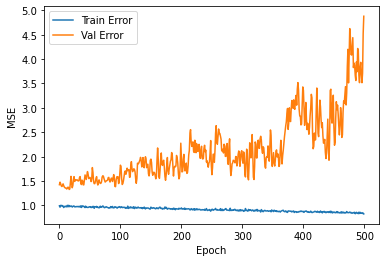

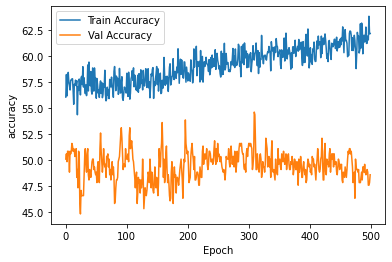

In [141]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
#   plt.ylim([0,])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
  plt.plot(hist['epoch'], hist['right_direction'],
           label='Train Accuracy')
  plt.plot(hist['epoch'], hist['val_right_direction'],
           label = 'Val Accuracy')
#   plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

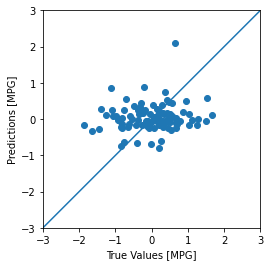

In [129]:
test_data = X[1000:1100]
test_labels = y[1000:1100]
test_predictions = model.predict(test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
_ = plt.plot([-3, 3], [-3, 3])


(array([ 2.,  2.,  2.,  0.,  0.,  0.,  2.,  8., 11.,  7., 20.,  6., 10.,
         7.,  8.,  2.,  2.,  4.,  2.,  1.,  0.,  1.,  0.,  2.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([-0.7888214 , -0.7168476 , -0.64487386, -0.57290006, -0.5009263 ,
        -0.42895252, -0.35697874, -0.28500497, -0.2130312 , -0.14105742,
        -0.06908365,  0.00289013,  0.0748639 ,  0.14683768,  0.21881145,
         0.29078522,  0.362759  ,  0.4347328 ,  0.50670654,  0.57868034,
         0.6506541 ,  0.7226279 ,  0.7946017 ,  0.8665754 ,  0.9385492 ,
         1.010523  ,  1.0824968 ,  1.1544706 ,  1.2264444 ,  1.298418  ,
         1.3703918 ,  1.4423656 ,  1.5143394 ,  1.5863131 ,  1.6582869 ,
         1.7302607 ,  1.8022345 ,  1.8742083 ,  1.946182  ,  2.0181558 ,
         2.0901296 ], dtype=float32),
 <BarContainer object of 40 artists>)

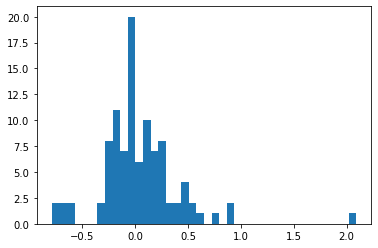

In [130]:
plt.hist(test_predictions, bins=40)

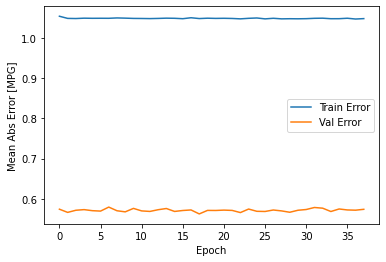

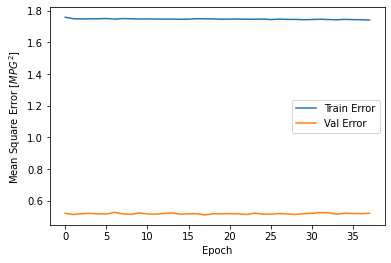

In [11]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_set, train_label, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop])

plot_history(history)